In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import shap
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("/kaggle/input/dapprojekt24-1/train.csv") # data on which all research and improvement will be done on
test_data = pd.read_csv("/kaggle/input/dapprojekt24-1/test.csv") # used for predictions at the end of notebook

# EDA

In this part explanatory data analysis is done in the same way as the previous mandatory notebook.

In [3]:
data = data[~data['Symbol'].isin(['VLTO', 'KVUE', 'GEHC', 'CTVA', 'FOXA'])]
grouped_data = data.groupby('Symbol').apply(lambda x: x.isnull().sum(), include_groups=False)
grouped_data = grouped_data[~(grouped_data == 0).all(axis=1)]

In [4]:
def find_missing_value_intervals(stock):
    missing_intervals = []
    current_interval_start = None
    current_interval_end = None

    for index, row in stock.iterrows():
        if pd.isnull(row).any(): # check if any values in the current row are missing
            current_interval_end = row['Date']
            if current_interval_start is None:
                current_interval_start = row['Date']
        else:
            if current_interval_start is not None:
                missing_intervals.append((current_interval_start, current_interval_end))
                return missing_intervals

    return missing_intervals

In [5]:
data['Date'] = pd.to_datetime(data['Date']).dt.date
grouped = data.groupby('Symbol') # group data by 'Symbol'
symbols = grouped_data.index.tolist() # get names of stock that have missing values

missing_value_intervals = {}
for name, group in grouped:
    if name in symbols: # only if name of group is in list of stocks that have missing values
        missing_value_intervals[name] = find_missing_value_intervals(group)

sorted_missing_values = sorted(missing_value_intervals.items(), key=lambda x:x[1]) # sort intervals
for stock, intervals in sorted_missing_values:
    for interval in intervals:
        start_date = interval[0].strftime('%d.%m.%Y') 
        end_date = interval[1].strftime('%d.%m.%Y')  

for stock, intervals in sorted_missing_values:
    if stock != 'MMM': # remove all stocks except 'MMM'
        for interval in intervals:
            start_date, end_date = interval
            rows_to_remove = data[(data['Symbol'] == stock) & (data['Date'] >= start_date) & (data['Date'] <= end_date)]
            data.drop(rows_to_remove.index, inplace=True)

interpolated_row = data['Volume'].interpolate()
data['Volume'] = interpolated_row
data.loc[data['High'] < 0, 'High'] = data.loc[data['High'] < 0, 'Close'] # copy value from 'Close' column to 'High' column

Because test dataset has NaN values, all NaN values are replaced with zeros so that machine learning can be done.

In [6]:
test_data.fillna(0, inplace=True) # replace all NaN values in test set with zeros

# 1. Cross-validation function

For cross validation sklearn function cross_val_score is used.

In [7]:
def CrossValidation(X, y, models):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    res = {}
    for model in models:
        res[model[0]] = cross_val_score(model[1], X, y, cv=kf, scoring='f1')
    
    results_df = pd.DataFrame.from_dict(res)
    results_df = results_df.T
    results_df.columns = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
    results_df['Average'] = results_df.mean(axis=1)
    print(tabulate(results_df, headers='keys', tablefmt='grid'))

# 2. Run the cross-validation function

In [8]:
X = data[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].copy() # get numerical values
y = data['Target'].copy()
models = [['GaussianNB', GaussianNB()], 
          ['LogisticRegression', LogisticRegression()], 
          ['RandomForestClassifier', RandomForestClassifier()],
          ['ExtraTreesClassifier', ExtraTreesClassifier()], 
          ['XGBClassifier', XGBClassifier()]]
CrossValidation(X, y, models)

+------------------------+----------+----------+----------+----------+----------+-----------+
|                        |   Fold 1 |   Fold 2 |   Fold 3 |   Fold 4 |   Fold 5 |   Average |
+========================+==========+==========+==========+==========+==========+===========+
| GaussianNB             | 0.876051 | 0.875555 | 0.874767 | 0.876266 | 0.87661  |  0.87585  |
+------------------------+----------+----------+----------+----------+----------+-----------+
| LogisticRegression     | 0.877349 | 0.877402 | 0.876663 | 0.878184 | 0.877952 |  0.87751  |
+------------------------+----------+----------+----------+----------+----------+-----------+
| RandomForestClassifier | 0.88162  | 0.882177 | 0.882587 | 0.883374 | 0.883551 |  0.882662 |
+------------------------+----------+----------+----------+----------+----------+-----------+
| ExtraTreesClassifier   | 0.882064 | 0.882147 | 0.882148 | 0.883529 | 0.883202 |  0.882618 |
+------------------------+----------+----------+----------+-

After running the cell above, the best f1-score is obtained by ExtraTreesClassifier.

In [9]:
X = data[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].copy() # get numerical values
y = data['Target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split dataset for training and testing
X_to_predict = test_data[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].copy()

classifier = ExtraTreesClassifier().fit(X_train, y_train) # using this model because it accepts NaN values

"X = data[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].copy() # get numerical values\ny = data['Target'].copy()\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split dataset for training and testing\nX_to_predict = test_data[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].copy()\n\nclassifier = ExtraTreesClassifier().fit(X_train, y_train) # using this model because it accepts NaN values"

In [10]:
predicted_values = classifier.predict(X_to_predict)
submission = test_data.loc[:,test_data.columns.isin(('Id', ))].copy()
submission.loc[:,'Target'] = predicted_values
submission.to_csv("submission.csv", index=None)

'predicted_values = classifier.predict(X_to_predict)\nsubmission = test_data.loc[:,test_data.columns.isin((\'Id\', ))].copy()\nsubmission.loc[:,\'Target\'] = predicted_values\nsubmission.to_csv("submission.csv", index=None)'

Score obtained on the Public Leaderboard: 0.81212

# 3. New features

## Domain specific features

For domain specific features I chose following indicators:
*     **MOVING AVERAGE** - it's used to identify a price trend in the market
*     **RELATIVE STRENGTH INDEX** - technical momentum indicator that compares the magnitude of recent gains and losses over time
*     **STOHASTIC OSCILLATOR** - momentum indicator that compares prices to ranges of values over time
*     **ON-BALANCE VOLUME** - volume-based indicator that measures the cumulative trading activity from buyers and sellers
*     **PRECENTAGE PRICE OSCILLATOR** - technical momentum indicator that plots the difference between two moving averages, where one of these lines has been shifted by an amount proportional to gains on stock

In [11]:
def calcualte_stock_indicators(grouped_data):
    copied = grouped_data.copy()

    # MA
    grouped_data['Short_MA'] = grouped_data['Close'].rolling(window=20, min_periods=1).mean()
    grouped_data['Long_MA'] = grouped_data['Close'].rolling(window=200, min_periods=1).mean()

    # RSI
    copied['Change'] = grouped_data["Close"].diff().dropna() 
    copied['Up'] = copied['Change'].where(copied['Change'] > 0, 0)
    copied['Down'] = copied['Change'].where(copied['Change'] < 0, 0).abs()
    copied['Gain'] = copied['Up'].rolling(window=14, min_periods=1).mean()
    copied['Loss'] = copied['Down'].rolling(window=14, min_periods=1).mean()
    grouped_data['RSI'] = 100 - (100 / (1 + (copied['Gain'] / copied['Loss']))).fillna(0)

    # Stochastic Oscillator
    copied['low_K'] = grouped_data['Low'].rolling(14).min()
    copied['high_K'] = grouped_data['High'].rolling(14).max()
    grouped_data['K'] = (100 * (grouped_data['Close'] - copied['low_K']) / (copied['high_K'] - copied['low_K'])).fillna(0)
    grouped_data['D'] = grouped_data['K'].rolling(3).mean().fillna(0)

    # OBV
    grouped_data['OBV'] = (np.sign(grouped_data['Close'].diff()) * grouped_data['Volume']).fillna(0).cumsum()

    # PPO
    copied['Short_EMA'] = grouped_data['Close'].ewm(span=14, adjust=False).mean()
    copied['Long_EMA'] = grouped_data['Close'].ewm(span=50, adjust=False).mean()
    grouped_data['PPO'] = (((copied['Short_EMA'] - copied['Long_EMA']) / copied['Long_EMA']) * 100).fillna(0)

    return grouped_data

## History related features

For history related features I chose following indicators:
*     **STANDARD DEVIATION** - statistical measure of how prices are dispersed around the average price
*     **A/D LINE** -  indicator accounts for the trading range for the period and where the close is in relation to that range in addition to the closing price of the security for the period
*     **WILLIAMS PERCENT RANGE** - volatility indicator that charts the magnitude of recent price action
*     **MOVING AVERAGE CONVERGENCE DIVERGENCE** - technical momentum oscillator that plots two exponential moving averages, one of which has been subtracted from the other to create a signal line or "divergence"
*     **HISTORICAL VOLATILITY** - measure the standard deviation of daily returns over a certain period, indicating the degree of variation in the stock's price
*     **SHARPE RATION** - measures the return of your asset or portfolio by its risk
*     **PRICE RATE OF CHANGE** - measures the percentage change in price over a specified period
*     **AVERAGE TRUE RANGE** - measures volatility by calculating the average range between the highest and lowest prices over a specified period
*     **BOLLINGER BANDS** - set of three lines that represent volatility, which is the range in prices that they have historically traded within
*     **AROON INDICATOR** - indicator that measures the momentum and direction of a trend in relation to price levels

In [12]:
def calculate_historic_features(grouped_data):
    copied = grouped_data.copy()

    # standard deviation
    grouped_data['STD'] = grouped_data['Close'].rolling(window=20, min_periods=1).std().fillna(0)

    # A/D line
    copied['Multiplier'] = ((grouped_data['Close'] - grouped_data['Low']) - (grouped_data['High'] - grouped_data['Close'])) / (grouped_data['High'] - grouped_data['Low'])
    grouped_data['AD'] = (copied['Multiplier'] * grouped_data['Volume']).fillna(0).cumsum()

    # williams percent range
    copied['high_R'] = grouped_data['High'].rolling(14).max()
    copied['low_R'] = grouped_data['Low'].rolling(14).min()
    grouped_data['Williams_R'] = (-100 * ((copied['high_R'] - grouped_data['Close']) / (copied['high_R'] - copied['low_R']))).fillna(0)

    # MACD
    grouped_data['MACD'] = (grouped_data['Close'].ewm(span=14, adjust=False).mean() - grouped_data['Close'].ewm(span=26, adjust=False).mean()).fillna(0)

    # historical volatility
    copied['Returns'] = np.log(grouped_data['Close'] / grouped_data['Close'].shift(1)).fillna(0)
    grouped_data['HV'] = (copied['Returns'].rolling(252).std() * np.sqrt(252))

    # sharpe ration
    grouped_data['Sharpe'] = (copied['Returns'].mean() / grouped_data['HV']).fillna(0)
    grouped_data['HV'] = grouped_data['HV'].fillna(0)

    # ROC
    grouped_data['ROC'] = (grouped_data['Close'].diff(13) / grouped_data['Close'].shift(13) * 100).fillna(0)

    # ATR
    copied['TR'] = grouped_data['High'].combine(grouped_data['Close'].shift(1), max) - grouped_data['Low'].combine(grouped_data['Close'].shift(1), min)
    grouped_data['ATR'] = copied['TR'].rolling(14).mean().fillna(0)

    # Bollinger bands
    copied['SMA'] = grouped_data['Close'].rolling(window=20).mean()
    copied['SD'] = grouped_data['Close'].rolling(window=20).std()
    grouped_data['Upper_band'] = (copied['SMA'] + 2 * copied['SD']).fillna(0)
    grouped_data['Lower_band'] = (copied['SMA'] - 2 * copied['SD']).fillna(0)

    # Aroon indicator
    grouped_data['Aroon_up'] = (100 * grouped_data['High'].rolling(25).apply(lambda x: x.argmax()) / (25)).fillna(0)   
    grouped_data['Aroon_down'] = (100 * grouped_data['Low'].rolling(25).apply(lambda x: x.argmin()) / (25)).fillna(0)

    return grouped_data

In [13]:
new_features = data.groupby('Symbol', group_keys=False, sort=False, as_index=False).apply(calcualte_stock_indicators)
new_features = new_features.groupby('Symbol', group_keys=False, sort=False, as_index=False).apply(calculate_historic_features)

In [14]:
new_features_test = test_data.groupby('Symbol', group_keys=False, sort=False, as_index=False).apply(calcualte_stock_indicators)
new_features_test = new_features_test.groupby('Symbol', group_keys=False, sort=False, as_index=False).apply(calculate_historic_features)

# 4. Run the cross-validation function on new features

In [15]:
X = new_features[['Short_MA', 'Long_MA', 'RSI', 'K', 'D', 'OBV', 'PPO', 'STD', 'AD', 'Williams_R', 'MACD', 'HV', 'Sharpe', 'ROC', 'ATR', 'Upper_band', 'Lower_band', 'Aroon_up', 'Aroon_down']].copy() # get numerical values
y = new_features['Target'].copy()
models = [['GaussianNB', GaussianNB()], 
          ['LogisticRegression', LogisticRegression()], 
          ['RandomForestClassifier', RandomForestClassifier()],
          ['ExtraTreesClassifier', ExtraTreesClassifier()], 
          ['XGBClassifier', XGBClassifier()]]
CrossValidation(X, y, models)

+------------------------+----------+----------+----------+----------+----------+-----------+
|                        |   Fold 1 |   Fold 2 |   Fold 3 |   Fold 4 |   Fold 5 |   Average |
+========================+==========+==========+==========+==========+==========+===========+
| GaussianNB             | 0.877349 | 0.877402 | 0.876663 | 0.878184 | 0.877952 |  0.87751  |
+------------------------+----------+----------+----------+----------+----------+-----------+
| LogisticRegression     | 0.807823 | 0.807271 | 0.80629  | 0.809196 | 0.808505 |  0.807817 |
+------------------------+----------+----------+----------+----------+----------+-----------+
| RandomForestClassifier | 0.972326 | 0.972127 | 0.972789 | 0.972219 | 0.972024 |  0.972297 |
+------------------------+----------+----------+----------+----------+----------+-----------+
| ExtraTreesClassifier   | 0.935616 | 0.935515 | 0.933814 | 0.934035 | 0.938788 |  0.935553 |
+------------------------+----------+----------+----------+-

After running the cell above, the best f1-score is obtained by RandomForestClassifier.

In [16]:
X = new_features[['Short_MA', 'Long_MA', 'RSI', 'K', 'D', 'OBV', 'PPO', 'STD', 'AD', 'Williams_R', 'MACD', 'HV', 'Sharpe', 'ROC', 'ATR', 'Upper_band', 'Lower_band', 'Aroon_up', 'Aroon_down']].copy() # get numerical values
y = new_features['Target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split dataset for training and testing
X_to_predict = new_features_test[['Short_MA', 'Long_MA', 'RSI', 'K', 'D', 'OBV', 'PPO', 'STD', 'AD', 'Williams_R', 'MACD', 'HV', 'Sharpe', 'ROC', 'ATR', 'Upper_band', 'Lower_band', 'Aroon_up', 'Aroon_down']].copy() # get numerical values

classifier = RandomForestClassifier().fit(X_train, y_train) # using this model because it accepts NaN values

"X = new_features[['Short_MA', 'Long_MA', 'RSI', 'K', 'D', 'OBV', 'PPO', 'STD', 'AD', 'Williams_R', 'MACD', 'HV', 'Sharpe', 'ROC', 'ATR', 'Upper_band', 'Lower_band', 'Aroon_up', 'Aroon_down']].copy() # get numerical values\ny = new_features['Target'].copy()\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split dataset for training and testing\nX_to_predict = new_features_test[['Short_MA', 'Long_MA', 'RSI', 'K', 'D', 'OBV', 'PPO', 'STD', 'AD', 'Williams_R', 'MACD', 'HV', 'Sharpe', 'ROC', 'ATR', 'Upper_band', 'Lower_band', 'Aroon_up', 'Aroon_down']].copy() # get numerical values\n\nclassifier = RandomForestClassifier().fit(X_train, y_train) # using this model because it accepts NaN values"

In [17]:
X_to_predict.replace([np.inf, -np.inf], 0, inplace=True)

In [18]:
predicted_values = classifier.predict(X_to_predict)
submission = test_data.loc[:,test_data.columns.isin(('Id', ))].copy()
submission.loc[:,'Target'] = predicted_values
submission.to_csv("submission.csv", index=None)

'predicted_values = classifier.predict(X_to_predict)\nsubmission = test_data.loc[:,test_data.columns.isin((\'Id\', ))].copy()\nsubmission.loc[:,\'Target\'] = predicted_values\nsubmission.to_csv("submission.csv", index=None)'

Score obtained on the Public Leaderboard: 0.80943 

# 5. Wrapper method

In [19]:
X = new_features[['Short_MA', 'Long_MA', 'RSI', 'K', 'D', 'OBV', 'PPO', 'STD', 'AD', 'Williams_R', 'MACD', 'HV', 'Sharpe', 'ROC', 'ATR', 'Upper_band', 'Lower_band', 'Aroon_up', 'Aroon_down']].copy() # get numerical values
y = new_features['Target'].copy()
sfs = SFS(
    estimator = GaussianNB(), 
    n_features_to_select=12,
    direction='backward',
    scoring='f1',
    cv=3,
)
sfs = sfs.fit(X, y)
sfs.get_feature_names_out()

array(['STD', 'AD', 'Williams_R', 'MACD', 'HV', 'Sharpe', 'ROC', 'ATR',
       'Upper_band', 'Lower_band', 'Aroon_up', 'Aroon_down'], dtype=object)

# 6. Run the cross-validation function on selected features

In [20]:
X = new_features[sfs.get_feature_names_out()]
y = new_features['Target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split dataset for training and testing
X_to_predict = new_features_test[sfs.get_feature_names_out()].copy() # get numerical values

classifier = RandomForestClassifier().fit(X_train, y_train)

"X = new_features[sfs.get_feature_names_out()]\ny = new_features['Target'].copy()\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split dataset for training and testing\nX_to_predict = new_features_test[sfs.get_feature_names_out()].copy() # get numerical values\n\nclassifier = RandomForestClassifier().fit(X_train, y_train)"

In [21]:
X_to_predict.replace([np.inf, -np.inf], 0, inplace=True)

In [22]:
predicted_values = classifier.predict(X_to_predict)
submission = test_data.loc[:,test_data.columns.isin(('Id', ))].copy()
submission.loc[:,'Target'] = predicted_values
submission.to_csv("submission.csv", index=None)

'predicted_values = classifier.predict(X_to_predict)\nsubmission = test_data.loc[:,test_data.columns.isin((\'Id\', ))].copy()\nsubmission.loc[:,\'Target\'] = predicted_values\nsubmission.to_csv("submission.csv", index=None)'

Score obtained on the Public Leaderboard: 0.81750

There is a slight improvement in the f1-score when compared to baseline model.

# 7. Explainability with SHAP

## Train the whole set on best ensambe algorithm

In [23]:
columns_to_exclude = ['Date', 'Symbol', 'Target', 'Id']
X = new_features[[col for col in new_features.columns if col not in columns_to_exclude]]
y = new_features['Target'].copy()

classifier = RandomForestClassifier().fit(X, y)

## Extract five samples

In [24]:
def find_samples(data_filtered):
    for i in range(len(data_filtered), 4, -1):
        if data_filtered['Target'].iloc[i - 5: i].eq(1).all() and data_filtered['Target'].iloc[i - 10 : i - 5].eq(0).any():
            return data_filtered.iloc[i - 10 : i]
    return Null

In [25]:
filtered_df = new_features[new_features['Symbol'] == 'MMM']
samples = find_samples(filtered_df)
samples

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id,...,Williams_R,MACD,HV,Sharpe,ROC,ATR,Upper_band,Lower_band,Aroon_up,Aroon_down
2402,2019-08-02,MMM,139.322891,170.550003,172.919998,169.809998,172.860001,2423100.0,0,2402,...,-95.868200,0.547940,0.257655,0.001167,-3.365631,4.399285,181.199203,165.735796,72.0,24.0
2403,2019-08-05,MMM,134.552170,164.710007,169.020004,164.419998,168.949997,2894700.0,1,2403,...,-98.755328,-0.061187,0.259817,0.001157,-5.702176,4.513572,181.720646,164.766353,68.0,20.0
2404,2019-08-06,MMM,133.735306,163.710007,165.479996,162.899994,164.820007,3494800.0,1,2404,...,-96.736452,-0.608648,0.259697,0.001158,-5.402745,4.527143,182.030769,164.257232,64.0,96.0
2405,2019-08-07,MMM,133.678101,163.639999,163.949997,158.039993,162.000000,5993200.0,1,2405,...,-81.132060,-1.046105,0.259690,0.001158,-5.196687,4.753572,182.329706,163.752294,60.0,96.0
2406,2019-08-08,MMM,134.151901,164.220001,165.490005,163.550003,164.369995,3260100.0,1,2406,...,-79.177876,-1.352449,0.259538,0.001158,-5.966559,4.765000,182.752209,162.847792,56.0,92.0
2407,2019-08-09,MMM,133.539215,163.470001,164.750000,162.029999,164.539993,1582100.0,1,2407,...,-81.704830,-1.629367,0.259495,0.001159,-7.914603,4.739286,183.090086,161.522916,52.0,88.0
2408,2019-08-12,MMM,132.420074,162.100006,164.779999,161.550003,163.020004,1473800.0,1,2408,...,-86.320715,-1.916678,0.259389,0.001159,-9.653323,4.728571,183.471752,160.067251,48.0,84.0
2409,2019-08-13,MMM,134.691055,164.880005,167.880005,162.149994,162.559998,3244600.0,1,2409,...,-76.954145,-1.963565,0.259680,0.001158,-7.438387,4.853571,183.055984,159.322019,44.0,80.0
2410,2019-08-14,MMM,129.732468,158.809998,162.869995,158.669998,162.500000,4056100.0,1,2410,...,-96.216196,-2.341501,0.262084,0.001147,-8.719392,4.507143,183.353141,157.438862,40.0,76.0
2411,2019-08-15,MMM,129.295517,156.839996,159.699997,155.630005,158.059998,4452700.0,1,2411,...,-94.595840,-2.738398,0.262303,0.001146,-11.269517,4.239286,183.808625,155.361378,36.0,96.0


## Use the TreeExplainer from the SHAP library

In [26]:
X_mmm = samples[[col for col in new_features.columns if col not in columns_to_exclude]]

In [27]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_mmm)

## Plot force plots

In [28]:
shap.initjs()

In [29]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_mmm.iloc[0, :])

In [30]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1], X_mmm.iloc[1, :])

In [31]:
shap.force_plot(explainer.expected_value[1], shap_values[1][2], X_mmm.iloc[2, :])

In [32]:
shap.force_plot(explainer.expected_value[1], shap_values[1][3], X_mmm.iloc[3, :])

In [33]:
shap.force_plot(explainer.expected_value[1], shap_values[1][4], X_mmm.iloc[4, :])

In [34]:
shap.force_plot(explainer.expected_value[1], shap_values[1][5], X_mmm.iloc[5, :])

In [35]:
shap.force_plot(explainer.expected_value[1], shap_values[1][6], X_mmm.iloc[6, :])

In [36]:
shap.force_plot(explainer.expected_value[1], shap_values[1][7], X_mmm.iloc[7, :])

In [37]:
shap.force_plot(explainer.expected_value[1], shap_values[1][8], X_mmm.iloc[8, :])

In [38]:
shap.force_plot(explainer.expected_value[1], shap_values[1][9], X_mmm.iloc[9, :])

From the force plots we can see that shap examiner accurately predicted tergets. We can also see that 'HV', 'Adj Close' and 'PPO' have the most impact.

## Plot signals

In [39]:
def plot_graphs(data, symbol, columns):
    fig, ax = plt.subplots(2, 3, figsize=(20,15))
    for i, j in enumerate(columns):
        k = i // 3
        l = i % 3
        ax[k, l].plot(data['Date'], data[j], label=j)
        ax[k, l].title.set_text(j)
        ax[k, l].tick_params(axis='x', rotation=40)
        ax[k, l].set_xlabel('Date')
        ax[k, l].set_ylabel(j)
    plt.show()

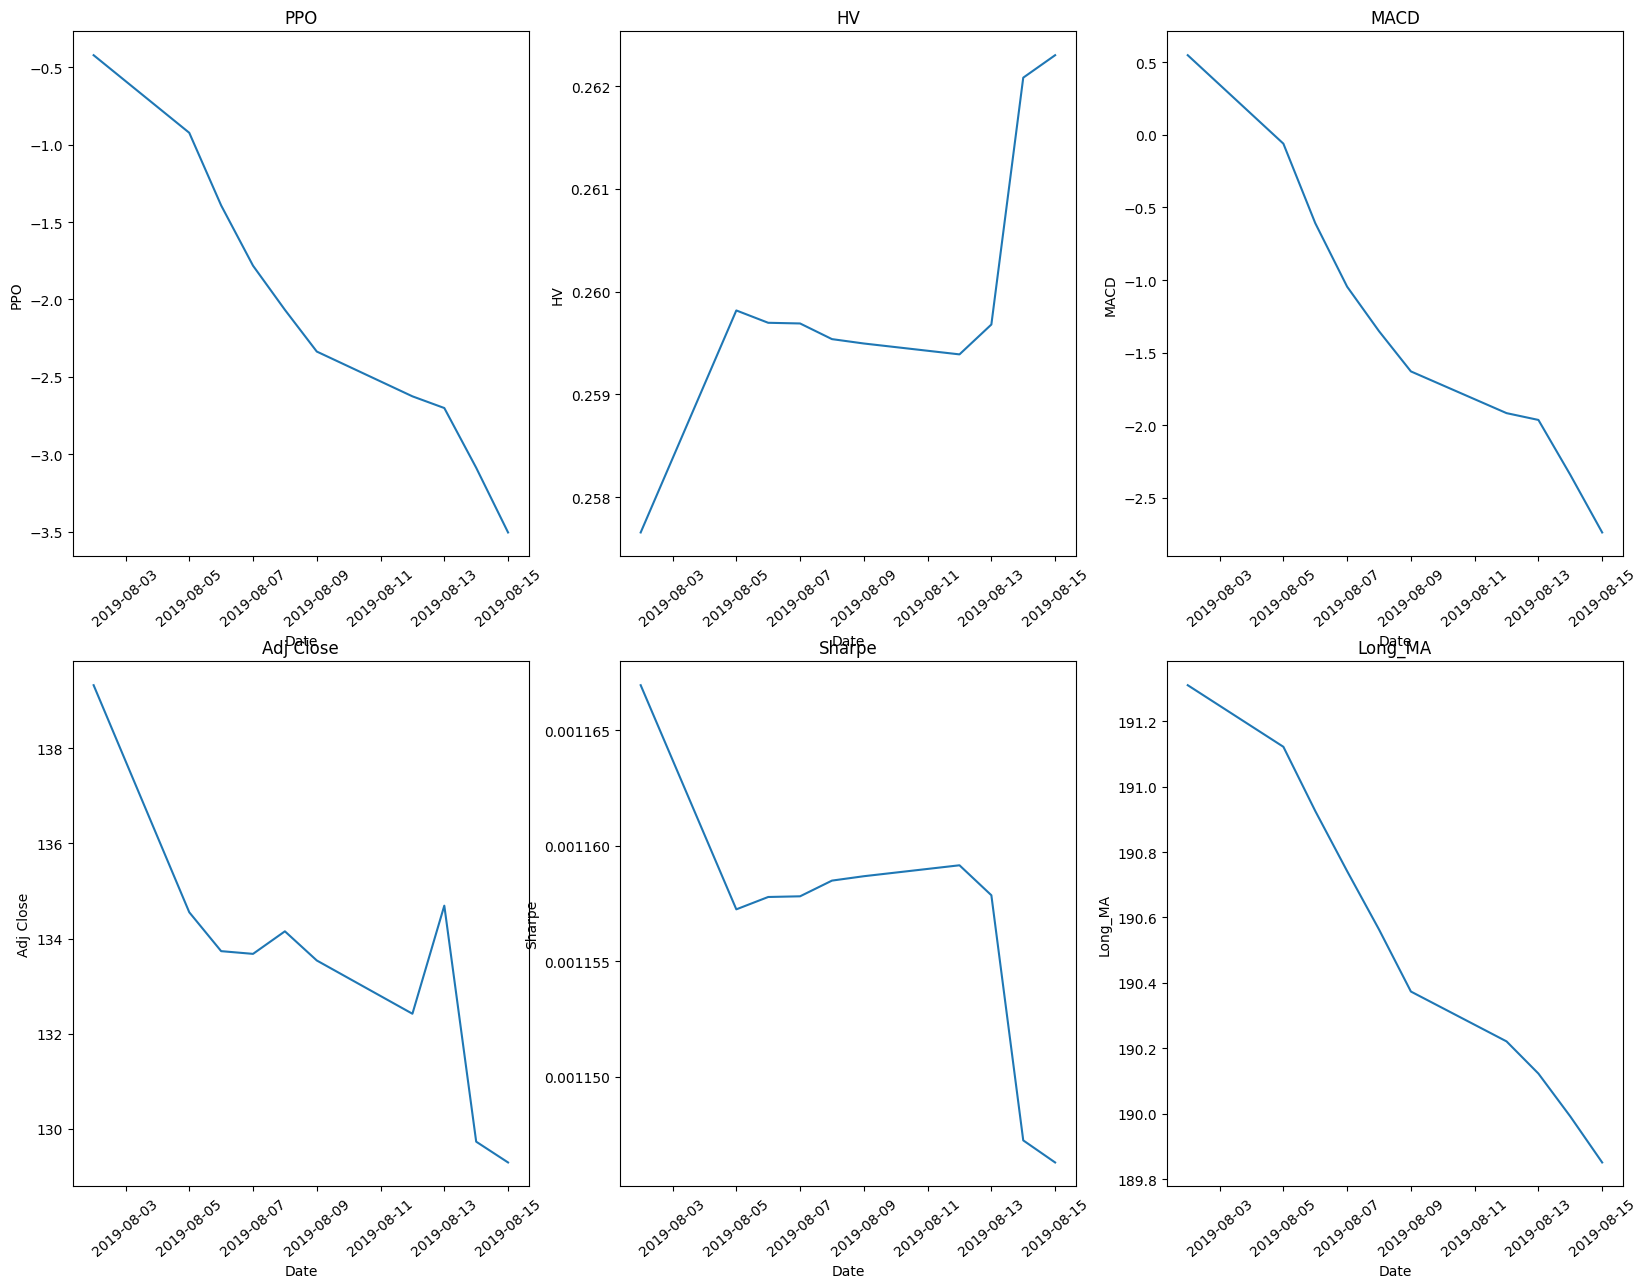

In [40]:
columns = ['PPO', 'HV', 'MACD', 'Adj Close', 'Sharpe', 'Long_MA']
plot_graphs(samples, 'MMM', columns)

# 8. RIPPER optimization

In [41]:
%%capture
!pip install Wittgenstein

In [42]:
import wittgenstein as lw

In [43]:
columns_to_exclude = ['Date', 'Symbol', 'Target', 'Id']
X = filtered_df[[col for col in new_features.columns if col not in columns_to_exclude]]
y = filtered_df['Target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split dataset for training and testing

classifier = lw.RIPPER(random_state=42)
classifier.fit(X_train, y_train)

In [44]:
y_pred = classifier.predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

F1 score: 0.8706677937447167


In [45]:
for i, j in enumerate(classifier.ruleset_):
        print(f'{i+1}. {j}')

1. [Short_MA=95.44-129.52]
2. [High=191.9-208.98^AD=315913352.52-371344061.24]
3. [Sharpe=0.0011-0.0013^High=163.22-172.42]
4. [Lower_band=123.76-141.4^HV=0.15-0.16]
5. [OBV=<-27222540.0^Close=<84.19]
6. [OBV=-27222540.0--7175604.71^Sharpe=<0.0011^HV=<0.13]
7. [Lower_band=123.76-141.4^ATR=2.97-3.57]
8. [Sharpe=0.0011-0.0013^Upper_band=198.21-214.89]
9. [OBV=<-27222540.0^Sharpe=0.0011-0.0013^HV=>0.26]
10. [ROC=-4.74--2.4^RSI=<30.58]
11. [Sharpe=>0.0023^High=172.42-191.9]
12. [Long_MA=83.42-86.91^AdjClose=55.37-60.38^AD=83594095.79-108191342.34]
13. [Lower_band=123.76-141.4^ATR=2.51-2.97]
14. [Open=190.66-207.92^OBV=250055208.24-274390628.24]
15. [Sharpe=0.0015-0.0016^Long_MA=143.57-156.11]
16. [RSI=30.58-38.32^Upper_band=91.31-100.88]
17. [OBV=<-27222540.0^HV=0.14-0.15]
18. [Sharpe=>0.0023^Long_MA=189.83-206.13]
19. [AdjClose=60.38-66.25^PPO=-1.17--0.3]
20. [PPO=0.36-1.01^Aroon_up=64.0-76.0]
21. [MACD=0.22-0.44^Aroon_down=<4.0]
22. [Sharpe=0.0018-0.002^Close=171.25-190.91]
23. [Aroon_do

We can see there are 39 rules, which is a lot. These rules are used when predicting tergets for each sample.

In [46]:
param_grid = {
    'k': [1, 2, 3],  # Number of optimization iterations
    'prune_size': [0.2, 0.5, 0.8],  # Proportion of training set to use for pruning
    'dl_allowance': [1, 2, 3]  # Description length allowance
}

classifier = lw.RIPPER(random_state=42)

grid = GridSearchCV(classifier, param_grid, scoring='f1')
grid.fit(X_train, y_train)

print(grid.best_params_)

{'dl_allowance': 3, 'k': 2, 'prune_size': 0.2}


In [47]:
classifier = grid.best_estimator_
classifier.fit(X_train, y_train)

In [48]:
y_pred = classifier.predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

F1 score: 0.6720647773279352


In [49]:
for i, j in enumerate(classifier.ruleset_):
        print(f'{i+1}. {j}')

1. [AdjClose=66.25-91.84]
2. [HV=<0.13^OBV=-27222540.0--7175604.71]
3. [Open=190.66-207.92^Close=190.91-207.86]
4. [Lower_band=123.76-141.4^HV=0.15-0.16]
5. [Sharpe=0.0011-0.0013^AD=371344061.24-387995310.81^HV=>0.26]
6. [OBV=<-27222540.0^Close=<84.19]
7. [Lower_band=123.76-141.4^ATR=2.97-3.57]
8. [Long_MA=83.42-86.91^AD=83594095.79-108191342.34]
9. [Sharpe=>0.0023^Short_MA=170.53-191.22]


Here we have a lot smaller number of rules, but also worse f1-score.

In [50]:
classifier = lw.RIPPER(random_state=42, max_rules = 3, max_rule_conds = 2)

grid = GridSearchCV(classifier, param_grid, scoring='f1')
grid.fit(X_train, y_train)

print(grid.best_params_)

{'dl_allowance': 1, 'k': 1, 'prune_size': 0.2}


In [51]:
classifier = grid.best_estimator_
classifier.fit(X_train, y_train)

In [52]:
y_pred = classifier.predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

F1 score: 0.4145454545454545


In [53]:
for i, j in enumerate(classifier.ruleset_):
        print(f'{i+1}. {j}')

1. [AdjClose=66.25-91.84]
2. [HV=<0.13^OBV=-27222540.0--7175604.71]
3. [Open=190.66-207.92^Close=190.91-207.86]


After setting max_rules to three we see that f1-score is around 40%, which is the worst score obtained in the whole notebook.

Also, rules are the same like the first three rules when number of rules was not limited.

RIPPER algorithm is not better than other algorithms, it's actually sometimes worse. Positive side of RIPPER is that it works relatively fast and is good with numerical features. Downside is that it is not ver accurate.